In [4]:
%pip install point-cloud-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 2.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import open3d as o3d
import numpy as np
import point_cloud_utils as pcu

In [5]:
print("Testing IO for point cloud ...")
sample_pcd_data = o3d.data.PCDPointCloud()
pcd = o3d.io.read_point_cloud("/home/vlad/Lab_related_stuff/car.ply")
print(pcd)
o3d.io.write_point_cloud("copy_of_fragment.pcd", pcd)

Testing IO for point cloud ...
PointCloud with 151757 points.


True

In [6]:
print("Load a ply point cloud, print it, and render it")
ply_point_cloud = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud("/home/vlad/Lab_related_stuff/Arch.ply")
#print(pcd)
#print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd])



aabb = pcd.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)
obb = pcd.get_oriented_bounding_box()
obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([pcd, aabb, obb])
x = np.asarray(obb.get_box_points())
print(x)

obb.volume()


Load a ply point cloud, print it, and render it
[[ 1.07076887  0.49715754  0.83005751]
 [ 1.26622805 -0.80911457  0.73557315]
 [ 0.27439615  0.3752837   0.86754558]
 [ 1.04617629  0.52477215  0.39740343]
 [ 0.44526275 -0.9033738   0.34040714]
 [ 0.24980357  0.40289831  0.4348915 ]
 [ 1.24163547 -0.78149996  0.30291908]
 [ 0.46985533 -0.93098841  0.77306122]]


0.46375055111286756

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[ 1.07076887  0.49715754  0.83005751]
 [ 1.26622805 -0.80911457  0.73557315]
 [ 0.27439615  0.3752837   0.86754558]
 [ 1.04617629  0.52477215  0.39740343]
 [ 0.44526275 -0.9033738   0.34040714]
 [ 0.24980357  0.40289831  0.4348915 ]
 [ 1.24163547 -0.78149996  0.30291908]
 [ 0.46985533 -0.93098841  0.77306122]]


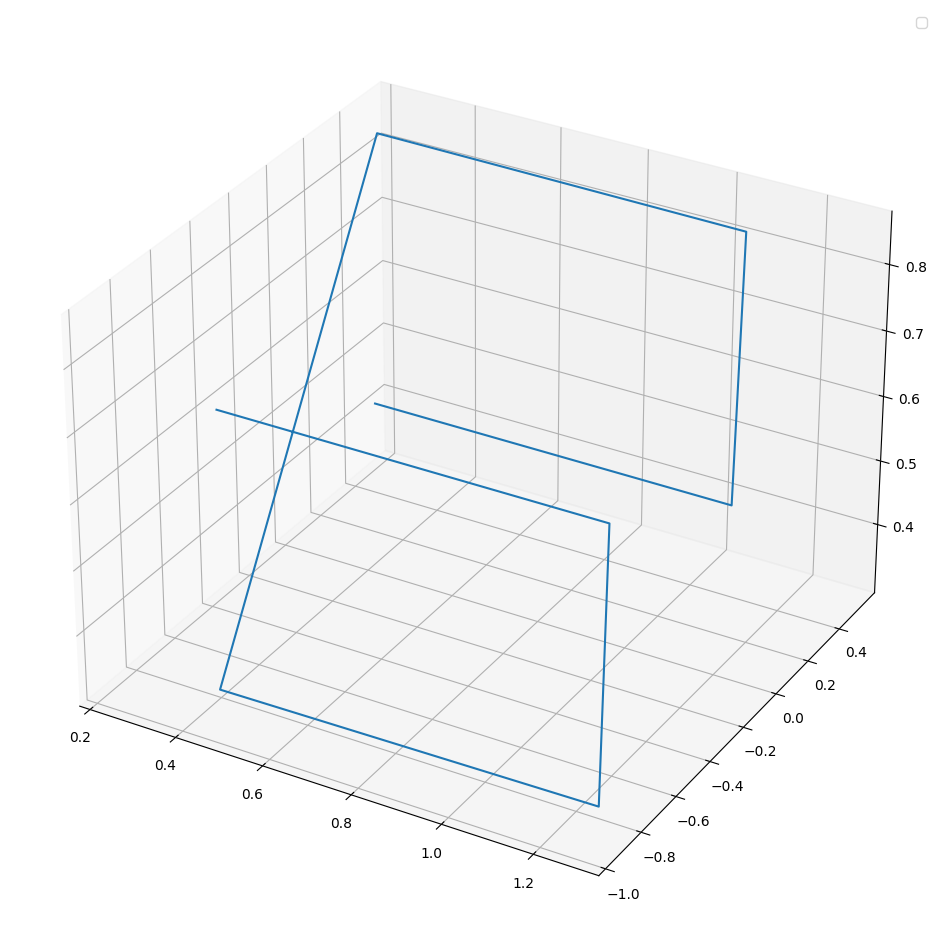

In [9]:
import matplotlib.pyplot as plt


# A = np.array([[ 1.07076887,  0.49715754,  0.83005751],
# [ 1.26622805, -0.80911457, 0.73557315],
# [ 0.27439615,  0.3752837,   0.86754558],
# [ 1.04617629,  0.52477215,  0.39740343],
# [ 0.44526275, -0.9033738,   0.34040714],
# [ 0.24980357,  0.40289831,  0.4348915 ],
# [ 1.24163547, -0.78149996,  0.30291908],
# [ 0.46985533, -0.93098841,  0.77306122]])

A = np.array([[ 1.07076887,  0.49715754,  0.83005751],
[ 1.26622805, -0.80911457, 0.73557315],
[ 0.27439615,  0.3752837,   0.86754558],
[ 1.04617629,  0.52477215,  0.39740343],
[ 0.44526275, -0.9033738,   0.34040714],
[ 0.24980357,  0.40289831,  0.4348915 ],
[ 1.24163547, -0.78149996,  0.30291908],
[ 0.46985533, -0.93098841,  0.77306122]])

A_new = np.zeros_like(A)
A_new[0] = A[7]
A_new[1] = A[1]
A_new[2] = A[6]
A_new[3] = A[4]
A_new[4] = A[2]
A_new[5] = A[0]
A_new[6] = A[3]
A_new[7] = A[5]
print(A)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')


#plt.plot(A[:, 0], A[:, 1], A[:, 2],'o', label = 'data')


#L = np.sqrt()

ax.plot(A_new[:, 0], A_new[:, 1], A_new[:, 2])
plt.legend()
plt.show()

In [7]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
#
# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree.

#%pip install pytorch3d
from typing import Tuple

import torch
import torch.nn.functional as F
from pytorch3d import _C
from torch.autograd import Function


# -------------------------------------------------- #
#                  CONSTANTS                         #
# -------------------------------------------------- #
"""
_box_planes and _box_triangles define the 4- and 3-connectivity
of the 8 box corners.
_box_planes gives the quad faces of the 3D box
_box_triangles gives the triangle faces of the 3D box
"""
_box_planes = [
    [0, 1, 2, 3],
    [3, 2, 6, 7],
    [0, 1, 5, 4],
    [0, 3, 7, 4],
    [1, 2, 6, 5],
    [4, 5, 6, 7],
]
_box_triangles = [
    [0, 1, 2],
    [0, 3, 2],
    [4, 5, 6],
    [4, 6, 7],
    [1, 5, 6],
    [1, 6, 2],
    [0, 4, 7],
    [0, 7, 3],
    [3, 2, 6],
    [3, 6, 7],
    [0, 1, 5],
    [0, 4, 5],
]


def _check_coplanar(boxes: torch.Tensor, eps: float = 1e-4) -> None:
    faces = torch.tensor(_box_planes, dtype=torch.int64, device=boxes.device)
    verts = boxes.index_select(index=faces.view(-1), dim=1)
    B = boxes.shape[0]
    P, V = faces.shape
    # (B, P, 4, 3) -> (B, P, 3)
    v0, v1, v2, v3 = verts.reshape(B, P, V, 3).unbind(2)

    # Compute the normal
    e0 = F.normalize(v1 - v0, dim=-1)
    e1 = F.normalize(v2 - v0, dim=-1)
    normal = F.normalize(torch.cross(e0, e1, dim=-1), dim=-1)

    # Check the fourth vertex is also on the same plane
    mat1 = (v3 - v0).view(B, 1, -1)  # (B, 1, P*3)
    mat2 = normal.view(B, -1, 1)  # (B, P*3, 1)
    if not (mat1.bmm(mat2).abs() < eps).all().item():
        msg = "Plane vertices are not coplanar"
        raise ValueError(msg)

    return


def _check_nonzero(boxes: torch.Tensor, eps: float = 1e-4) -> None:
    """
    Checks that the sides of the box have a non zero area
    """
    faces = torch.tensor(_box_triangles, dtype=torch.int64, device=boxes.device)
    verts = boxes.index_select(index=faces.view(-1), dim=1)
    B = boxes.shape[0]
    T, V = faces.shape
    # (B, T, 3, 3) -> (B, T, 3)
    v0, v1, v2 = verts.reshape(B, T, V, 3).unbind(2)

    normals = torch.cross(v1 - v0, v2 - v0, dim=-1)  # (B, T, 3)
    face_areas = normals.norm(dim=-1) / 2

    if (face_areas < eps).any().item():
        msg = "Planes have zero areas"
        raise ValueError(msg)

    return


class _box3d_overlap(Function):
    """
    Torch autograd Function wrapper for box3d_overlap C++/CUDA implementations.
    Backward is not supported.
    """

    @staticmethod
    def forward(ctx, boxes1, boxes2):
        """
        Arguments defintions the same as in the box3d_overlap function
        """
        vol, iou = _C.iou_box3d(boxes1, boxes2)
        return vol, iou

    @staticmethod
    def backward(ctx, grad_vol, grad_iou):
        raise ValueError("box3d_overlap backward is not supported")


def box3d_overlap(
    boxes1: torch.Tensor, boxes2: torch.Tensor, eps: float = 1e-4
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes the intersection of 3D boxes1 and boxes2.

    Inputs boxes1, boxes2 are tensors of shape (B, 8, 3)
    (where B doesn't have to be the same for boxes1 and boxes2),
    containing the 8 corners of the boxes, as follows:

        (4) +---------+. (5)
            | ` .     |  ` .
            | (0) +---+-----+ (1)
            |     |   |     |
        (7) +-----+---+. (6)|
            ` .   |     ` . |
            (3) ` +---------+ (2)


    NOTE: Throughout this implementation, we assume that boxes
    are defined by their 8 corners exactly in the order specified in the
    diagram above for the function to give correct results. In addition
    the vertices on each plane must be coplanar.
    As an alternative to the diagram, this is a unit bounding
    box which has the correct vertex ordering:

    box_corner_vertices = [
        [0, 0, 0],
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 1],
    ]

    Args:
        boxes1: tensor of shape (N, 8, 3) of the coordinates of the 1st boxes
        boxes2: tensor of shape (M, 8, 3) of the coordinates of the 2nd boxes
    Returns:
        vol: (N, M) tensor of the volume of the intersecting convex shapes
        iou: (N, M) tensor of the intersection over union which is
            defined as: `iou = vol / (vol1 + vol2 - vol)`
    """
    if not all((8, 3) == box.shape[1:] for box in [boxes1, boxes2]):
        raise ValueError("Each box in the batch must be of shape (8, 3)")

    _check_coplanar(boxes1, eps)
    _check_coplanar(boxes2, eps)
    _check_nonzero(boxes1, eps)
    _check_nonzero(boxes2, eps)

    vol, iou = _box3d_overlap.apply(boxes1, boxes2)

    return vol, iou

In [28]:
# Calculate IoU 3D
import torch
boxes1 = torch.tensor(A_new, dtype=torch.float32)
boxes2 = torch.tensor(A_new, dtype=torch.float32)
box1 = boxes1.reshape((1,8,3))
box2 = boxes2.reshape((1,8,3))
print(box1.shape)
print(box1.shape[1:])
if not (8, 3) == box1.shape[1:]:
    raise ValueError("Each box in the batch must be of shape (8, 3)")
print(box3d_overlap(box1, box2))

torch.Size([1, 8, 3])
torch.Size([8, 3])
(tensor([[0.4638]]), tensor([[1.0000]]))
